In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/molecular-machine-learning/sample_submission.csv
/kaggle/input/molecular-machine-learning/train.csv
/kaggle/input/molecular-machine-learning/test.csv


In [2]:
!pip install jcopml

  Preparing metadata (setup.py) ... done
  Created wheel for jcopml: filename=jcopml-1.2.7-py2.py3-none-any.whl size=45916 sha256=cc34bfc7224953f8eba06f57dbe27a8ca6943e2beb29b031f7604cefe494fd0a
  Stored in directory: /root/.cache/pip/wheels/1b/f0/69/8cd4944dd9637953ab744056b5faa32617cd4de449b213e886
Successfully built jcopml


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe

In [4]:
df=pd.read_csv('/kaggle/input/molecular-machine-learning/train.csv', index_col='Batch_ID')
df.head()

,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,RingCount,...,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
Batch_ID,,,,,,,,,,,,,,,,,,,,,
Train-01,103.86,CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1,410.692,2,0,9.6070,0.301361,5.187321,0.00,3,...,1.717761,1.970186,1.760071,1.224983,0.664733,0.282353,0.096763,0.034589,0.030793,0.057340
Train-02,101.13,CCCCCCCCCCCCc1ccsc1-c1cccs1,334.594,2,0,7.9400,0.367472,4.141425,0.00,2,...,0.012396,0.046031,0.133124,0.299840,0.525958,0.718549,0.764711,0.634854,0.414866,0.225909
Train-03,78.30,CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1,398.553,4,0,4.0182,0.799589,5.368024,40.62,4,...,2.421162,2.703267,2.352276,1.595867,0.845839,0.354620,0.127878,0.060600,0.064782,0.098908
Train-04,71.88,O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21,372.470,4,0,5.9190,0.793825,4.948903,34.14,5,...,0.886320,0.579059,0.345148,0.246564,0.276259,0.381997,0.495304,0.566935,0.594203,0.614075
Train-05,68.37,CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...,457.620,5,0,8.5485,0.671148,5.994751,31.23,5,...,0.487723,0.245764,0.249019,0.363222,0.474953,0.505358,0.440671,0.330129,0.234649,0.183111


In [5]:
X = df.select_dtypes(include='number').drop(columns=['T80'])
y = df['T80']

pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=5000, random_state=42))
pipeline.fit(X, y)

coef = pipeline.named_steps['lassocv'].coef_
selected_features = X.columns[coef != 0]
selected_features

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.858e-01, tolerance: 2.190e-01
  model = cd_fast.enet_coordinate_descent(


Index(['S12', 'S16', 'TDOS4.0'], dtype='object')

In [6]:
X = df[selected_features]
y = df['T80']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((33, 3), (9, 3), (33,), (9,))

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

pipeline = Pipeline([
    ('algo', XGBRegressor())
])
model = RandomizedSearchCV(pipeline, rsp.xgb_params,n_iter=30, cv=3, n_jobs=-1, verbose=1, error_score='raise')

model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'algo__colsample_bytree': 0.2200694045301839, 'algo__gamma': 4, 'algo__learning_rate': 0.9138132001800371, 'algo__max_depth': 10, 'algo__n_estimators': 158, 'algo__reg_alpha': 0.5483548489539687, 'algo__reg_lambda': 1.1681863442007185, 'algo__subsample': 0.4885762317010929}
0.9986442020494779 0.40581356713121575 0.5712844603309792


In [8]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import random_search_params as rsp

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X.select_dtypes(include=np.number).columns),
   
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor())
])

model = RandomizedSearchCV(pipeline,rsp.xgb_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__colsample_bytree': 0.5205025097307954, 'algo__gamma': 9, 'algo__learning_rate': 0.04212348867053849, 'algo__max_depth': 10, 'algo__n_estimators': 126, 'algo__reg_alpha': 2.244577317236589, 'algo__reg_lambda': 2.3029565016935836, 'algo__subsample': 0.7810909884871855}
0.947159195643769 0.3129793946921005 0.2905415397069311


In [9]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 26.1 MB/s eta 0:00:00


In [10]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            "MolWt": Descriptors.MolWt(mol),
            "NumAromaticRings": Descriptors.NumAromaticRings(mol),
            "NumAliphaticRings": Descriptors.NumAliphaticRings(mol),
            "FractionCSP3": Descriptors.FractionCSP3(mol),
            "HeavyAtomCount": Descriptors.HeavyAtomCount(mol),
            "MolLogP": Descriptors.MolLogP(mol),
        }
    else:
        return {k: None for k in ['MolWt', 'NumAromaticRings', 'NumAliphaticRings', 'FractionCSP3', 'HeavyAtomCount', 'MolLogP']}

desc_df = df['Smiles'].apply(smiles_to_descriptors).apply(pd.Series)
desc_df['T80'] = df['T80']


In [11]:
desc_df

,MolWt,NumAromaticRings,NumAliphaticRings,FractionCSP3,HeavyAtomCount,MolLogP,T80
Batch_ID,,,,,,,
Train-01,410.692,3.0,0.0,0.461538,28.0,9.60700,103.86
Train-02,334.594,2.0,0.0,0.600000,22.0,7.94000,101.13
Train-03,398.553,3.0,1.0,0.238095,27.0,4.01820,78.30
Train-04,372.470,4.0,1.0,0.000000,26.0,5.91900,71.88
Train-05,457.620,5.0,0.0,0.148148,32.0,8.54850,68.37
Train-06,572.754,7.0,2.0,0.025641,42.0,11.27940,51.70
Train-07,425.575,3.0,1.0,0.304348,29.0,5.76450,48.00
Train-08,374.494,5.0,0.0,0.050000,26.0,5.55672,44.96
Train-09,580.975,5.0,0.0,0.375000,37.0,13.12550,38.74


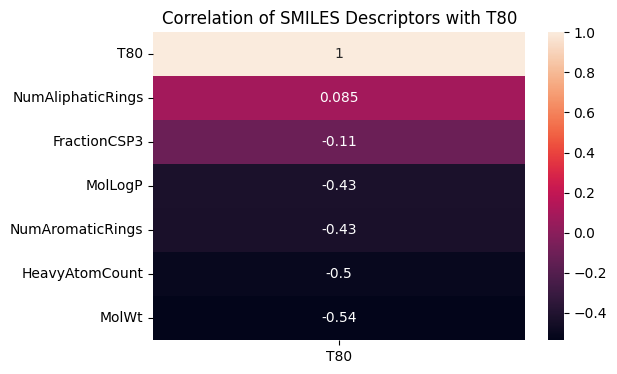

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


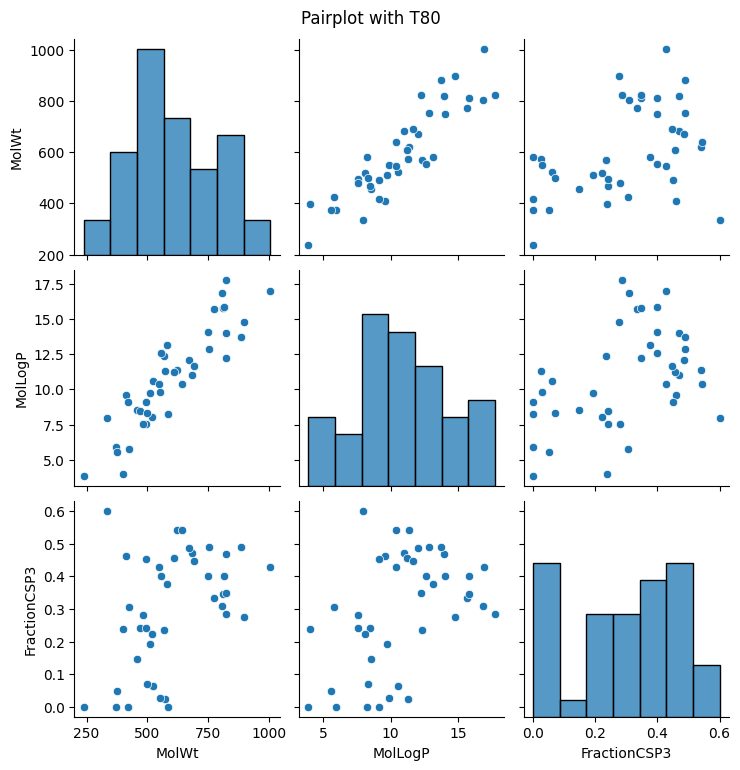

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.heatmap(desc_df.corr(numeric_only=True)[['T80']].sort_values(by='T80', ascending=False), annot=True)
plt.title('Correlation of SMILES Descriptors with T80')
plt.show()

# Scatter contoh
sns.pairplot(desc_df, vars=['MolWt', 'MolLogP', 'FractionCSP3'], hue=None, y_vars=['T80'])
plt.suptitle("Pairplot with T80", y=1.02)
plt.show()


In [13]:
desc_df.columns

Index(['MolWt', 'NumAromaticRings', 'NumAliphaticRings', 'FractionCSP3',
       'HeavyAtomCount', 'MolLogP', 'T80'],
      dtype='object')

In [14]:
df_nyoba = pd.concat([desc_df[['MolWt', 'HeavyAtomCount', 'MolLogP']], df[selected_features]], axis=1)


In [15]:

rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [16]:
X = df_nyoba
y = df['T80']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import random_search_params as rsp

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X.select_dtypes(include=np.number).columns),
   
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor())
])

model = RandomizedSearchCV(pipeline,rsp.xgb_params, cv=3, n_jobs=-1, verbose=1 )
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__colsample_bytree': 0.36020871022206413, 'algo__gamma': 1, 'algo__learning_rate': 0.019475882654112285, 'algo__max_depth': 8, 'algo__n_estimators': 194, 'algo__reg_alpha': 3.7691311079355945, 'algo__reg_lambda': 0.00725657378347783, 'algo__subsample': 0.4378766115478161}
0.9519087708529923 0.2695332344112625 0.28766738569603567
